In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter

from collections import OrderedDict
from collections import namedtuple
from itertools import product

#import RunBuilder
import RunManager 

In [3]:
dataset = torchvision.datasets.CIFAR10(
    root='./data/EMNIST',
    train = True,
    download = True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

Files already downloaded and verified


In [4]:
len(dataset)

50000

In [5]:
train_set, test_set = torch.utils.data.random_split(dataset,[40000,10000])
print('Length of training set:   ',len(train_set))
print('Length of training set:   ',len(test_set))

Length of training set:    40000
Length of training set:    10000


In [6]:
train_loaded = torch.utils.data.DataLoader(train_set, batch_size=100)

In [7]:
batch = next(iter(train_loaded))
print(len(batch))
images,labels = batch

2



Bad key "text.kerning_factor" on line 4 in
C:\Users\muhammad.tariq\.conda\envs\pytorch\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


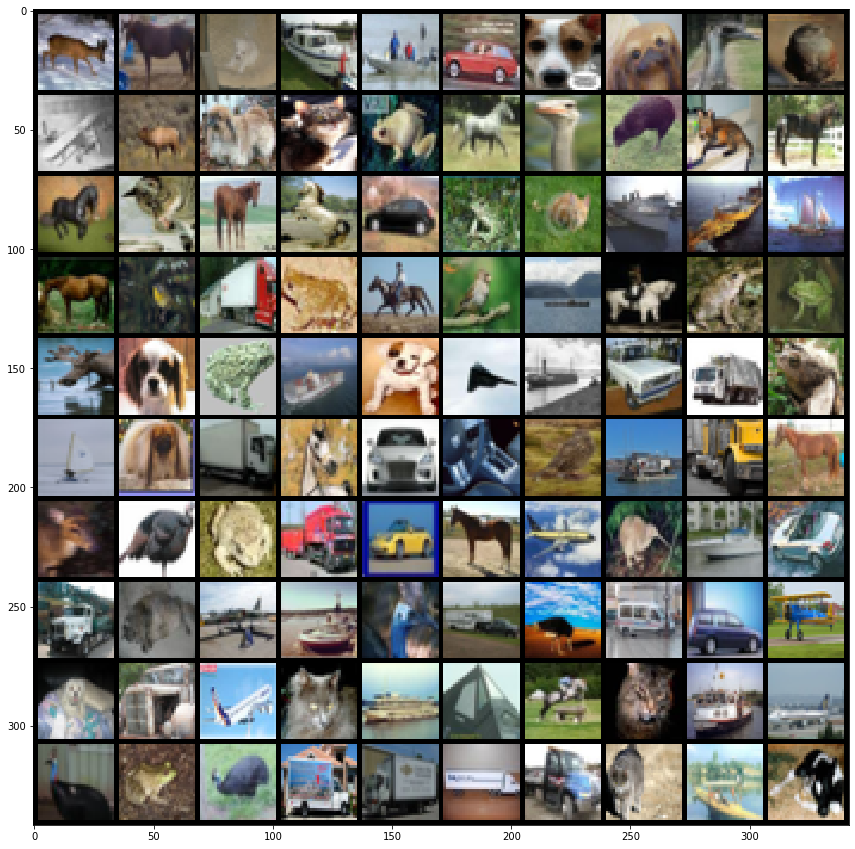

In [8]:
grid = torchvision.utils.make_grid(images,nrow=10)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        # Three fully-connected layers
        self.fc1 = nn.Linear(in_features=12*5*5, out_features=120) 
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self,t):
        
        # Forward Propagation
        
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t,kernel_size=2, stride=2)
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t,kernel_size=2, stride=2)
        
        t = t.reshape(-1,12*5*5)
        t = F.relu(self.fc1(t))
        
        t = F.relu(self.fc2(t))
        
        t = self.out(t)
        
        return t

In [10]:
class RunBuilder():
    
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

#### Training Loop

In [12]:
def Train_Network(train_set):
    params = OrderedDict(
        lr = [.01],
        batch_size = [1000,2000]
    )
    m = RunManager.RunManager()
    for run in RunBuilder.get_runs(params):

        network = Network()
        train_loader = torch.utils.data.DataLoader(train_set,batch_size = run.batch_size)
        optimizer = optim.Adam(network.parameters(), lr=run.lr)

        m.begin_run(run,network,train_loader)
        for epoch in range(5):
            m.begin_epoch()
            for batch in train_loader:
                images, labels = batch
                preds = network(images)
                loss = F.cross_entropy(preds,labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                m.track_loss(loss)
                m.track_num_correct(preds,labels)
            m.end_epoch()
        m.end_run()
    m.save('results')
    
print('Training is done and Model has been is saved ')    

Training is done and Model has been is saved 


In [13]:
Train_Network(train_set)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size
0,1,1,2.303762,0.102375,28.809248,32.978942,0.01,1000
1,1,2,2.306738,0.102900,31.791204,65.084259,0.01,1000
2,1,3,2.303053,0.097650,32.419285,97.677080,0.01,1000
3,1,4,2.302947,0.098750,27.396969,125.231707,0.01,1000
4,1,5,2.372797,0.101600,26.374028,151.777570,0.01,1000
5,2,1,2.222609,0.151225,27.156230,32.835249,0.01,2000
6,2,2,2.025321,0.238625,29.274981,62.295639,0.01,2000
7,2,3,1.937908,0.272600,26.821776,89.319793,0.01,2000
8,2,4,1.862547,0.307100,24.324647,113.847519,0.01,2000
9,2,5,1.785568,0.344900,27.637454,141.729322,0.01,2000
